<a href="https://colab.research.google.com/github/2023garvitshrivastava-sketch/Data_Mining/blob/main/DataMining_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from collections import defaultdict
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
import warnings

# Ignore all deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [2]:
def load_with_sampling(file_path, sample_fraction=0.1, nrows=None):
    """Load only a sample of large datasets"""
    try:
        # First, get the total number of rows to sample appropriately
        if nrows is None:
            nrows = int(pd.read_csv(file_path, nrows=1) * sample_fraction)

        return pd.read_csv(file_path, nrows=nrows)
    except:
        # Fallback: use skiprows for very large files
        total_rows = sum(1 for line in open(file_path)) - 1  # minus header
        skip_rows = random.sample(range(1, total_rows), int(total_rows * (1-sample_fraction)))
        return pd.read_csv(file_path, skiprows=skip_rows)

# Load datasets directly (they're already in your Colab environment)
print("Loading datasets from Colab environment...")
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
products = pd.read_csv('products.csv')
departments = pd.read_csv('departments.csv')

print("Datasets loaded successfully!")
print(f"Orders shape: {orders.shape}")
print(f"Order Products Prior shape: {order_products_prior.shape}")
print(f"Products shape: {products.shape}")
print(f"Departments shape: {departments.shape}")

Loading datasets from Colab environment...
Datasets loaded successfully!
Orders shape: (3421083, 7)
Order Products Prior shape: (32434489, 4)
Products shape: (49688, 4)
Departments shape: (21, 2)


In [3]:
# Sample users to reduce data size further
def sample_users(orders_df, user_sample_fraction=0.3):
    """Sample a subset of users to reduce transaction volume"""
    unique_users = orders_df['user_id'].unique()
    sampled_users = np.random.choice(unique_users,
                                   size=int(len(unique_users) * user_sample_fraction),
                                   replace=False)
    return orders_df[orders_df['user_id'].isin(sampled_users)]

# Sample users before merging
print("Sampling users to reduce data size...")
orders_sampled = sample_users(orders, user_sample_fraction=0.3)

def create_efficient_hierarchy(orders_sampled, order_products_prior, products, departments):
    """Create hierarchical data efficiently with sampling"""

    # Merge in stages with sampled data
    print("Merging product information...")
    order_products_sampled = order_products_prior[order_products_prior['order_id'].isin(orders_sampled['order_id'])]

    # Merge with product info
    product_info = products[['product_id', 'product_name', 'department_id']]
    order_details = order_products_sampled.merge(product_info, on='product_id', how='inner')

    # Merge with department info
    dept_info = departments[['department_id', 'department']]
    order_details = order_details.merge(dept_info, on='department_id', how='left')

    # Merge with order info (only user_id needed)
    order_user_info = orders_sampled[['order_id', 'user_id']]
    order_details = order_details.merge(order_user_info, on='order_id', how='left')

    return order_details

# Create efficient hierarchy
order_hierarchy = create_efficient_hierarchy(orders_sampled, order_products_prior, products, departments)

print(f"Final hierarchical dataset shape: {order_hierarchy.shape}")
print(f"Memory usage: {order_hierarchy.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Sampling users to reduce data size...
Merging product information...
Final hierarchical dataset shape: (9818505, 8)
Memory usage: 1677.41 MB


In [4]:
# Extract brand information efficiently
def extract_brand_efficient(product_name):
    """Efficient brand extraction"""
    if pd.isna(product_name):
        return 'Unknown'
    return str(product_name).split()[0] if len(str(product_name).split()) > 0 else 'Unknown'

# Add brand information
order_hierarchy['brand'] = order_hierarchy['product_name'].apply(extract_brand_efficient)

# Remove duplicates and clean data
order_hierarchy = order_hierarchy.drop_duplicates()
print(f"Data shape after deduplication: {order_hierarchy.shape}")

Data shape after deduplication: (9818505, 9)


In [5]:
def prepare_efficient_transactions_fast(order_hierarchy, level='all', user_sample_fraction=1.0):
    """MUCH FASTER version using groupby and vectorized operations"""

    # Sample users first (much faster)
    if user_sample_fraction < 1.0:
        unique_users = order_hierarchy['user_id'].unique()
        sampled_users = np.random.choice(unique_users,
                                       size=int(len(unique_users) * user_sample_fraction),
                                       replace=False)
        order_subset = order_hierarchy[order_hierarchy['user_id'].isin(sampled_users)].copy()
    else:
        order_subset = order_hierarchy.copy()

    print(f"Processing {len(order_subset)} rows for {level} level...")

    # Pre-compute the item strings
    if level == 'department' or level == 'all':
        order_subset['dept_item'] = 'DEPT_' + order_subset['department'].astype(str)

    if level == 'brand' or level == 'all':
        order_subset['brand_item'] = 'BRAND_' + order_subset['brand'].astype(str)

    if level == 'product' or level == 'all':
        order_subset['prod_item'] = 'PROD_' + order_subset['product_name'].astype(str).str[:30]

    # Use groupby which is MUCH faster than iterrows
    transactions_by_user = {}

    if level == 'department':
        transactions = order_subset.groupby('user_id')['dept_item'].apply(set).tolist()
    elif level == 'brand':
        transactions = order_subset.groupby('user_id')['brand_item'].apply(set).tolist()
    elif level == 'product':
        transactions = order_subset.groupby('user_id')['prod_item'].apply(set).tolist()
    else:  # 'all' levels
        # Combine all levels
        def combine_all_items(group):
            items = set()
            if 'dept_item' in group:
                items.update(group['dept_item'].unique())
            if 'brand_item' in group:
                items.update(group['brand_item'].unique())
            if 'prod_item' in group:
                items.update(group['prod_item'].unique())
            return items

        transactions = order_subset.groupby('user_id').apply(combine_all_items).tolist()

    # Filter out transactions with only 1 item
    transactions_list = [list(items) for items in transactions if len(items) > 1]

    print(f"Generated {len(transactions_list)} transactions for {level} level")
    return transactions_list

# Use the FAST version instead
print("Preparing transactions with FAST method...")
transactions_department = prepare_efficient_transactions_fast(order_hierarchy, 'department', user_sample_fraction=0.5)
transactions_brand = prepare_efficient_transactions_fast(order_hierarchy, 'brand', user_sample_fraction=0.5)
transactions_product = prepare_efficient_transactions_fast(order_hierarchy, 'product', user_sample_fraction=0.3)
transactions_all_levels = prepare_efficient_transactions_fast(order_hierarchy, 'all', user_sample_fraction=0.4)

print(f"Transaction counts - Dept: {len(transactions_department)}, Brand: {len(transactions_brand)}, Product: {len(transactions_product)}, All: {len(transactions_all_levels)}")

Preparing transactions with FAST method...
Processing 4918813 rows for department level...
Generated 30736 transactions for department level
Processing 4925569 rows for brand level...
Generated 30870 transactions for brand level
Processing 2925857 rows for product level...
Generated 18523 transactions for product level
Processing 3898033 rows for all level...
Generated 24744 transactions for all level
Transaction counts - Dept: 30736, Brand: 30870, Product: 18523, All: 24744


In [6]:
def mine_ultra_conservative_rules(transactions, level_name, min_support=0.05, min_confidence=0.5, max_items=2, sample_size=1000):
    """ULTRA CONSERVATIVE rule mining to prevent crashes"""

    if len(transactions) == 0:
        print(f"No transactions for {level_name} level")
        return pd.DataFrame(), pd.DataFrame()

    # Aggressive sampling
    if len(transactions) > sample_size:
        transactions = random.sample(transactions, sample_size)
        print(f"Sampled down to {len(transactions)} transactions for {level_name}")

    # Further reduce transaction size by limiting items per transaction
    trimmed_transactions = []
    for transaction in transactions:
        if len(transaction) > 10:  # Limit to 10 items per transaction
            trimmed_transactions.append(random.sample(transaction, 10))
        else:
            trimmed_transactions.append(transaction)

    transactions = trimmed_transactions

    try:
        # Use TransactionEncoder
        te = TransactionEncoder()
        te_ary = te.fit(transactions).transform(transactions)
        df = pd.DataFrame(te_ary, columns=te.columns_)

        print(f"{level_name} - Transaction matrix: {df.shape}")

        # Use higher min_support to reduce itemsets
        frequent_itemsets = apriori(df,
                                  min_support=min_support,
                                  use_colnames=True,
                                  max_len=max_items)

        print(f"{level_name} - Found {len(frequent_itemsets)} frequent itemsets")

        if len(frequent_itemsets) > 0:
            rules = association_rules(frequent_itemsets,
                                    metric="confidence",
                                    min_threshold=min_confidence)
            rules = rules.head(50)  # Limit rules
            print(f"{level_name} - Generated {len(rules)} rules")
        else:
            rules = pd.DataFrame()
            print(f"{level_name} - No rules generated")

        return frequent_itemsets, rules

    except Exception as e:
        print(f"Error in {level_name}: {e}")
        return pd.DataFrame(), pd.DataFrame()

print("Mining rules with ULTRA CONSERVATIVE parameters...")

# Department level - most conservative
freq_dept, rules_dept = mine_ultra_conservative_rules(
    transactions_department,
    "Department",
    min_support=0.05,    # Higher support
    min_confidence=0.6,  # Higher confidence
    max_items=2,
    sample_size=2000     # Very small sample
)

# Brand level - conservative
freq_brand, rules_brand = mine_ultra_conservative_rules(
    transactions_brand,
    "Brand",
    min_support=0.04,
    min_confidence=0.5,
    max_items=2,
    sample_size=2000
)

# Product level - most aggressive sampling
freq_product, rules_product = mine_ultra_conservative_rules(
    transactions_product,
    "Product",
    min_support=0.03,
    min_confidence=0.4,
    max_items=2,
    sample_size=1500     # Smallest sample
)

# All levels - very conservative
freq_all, rules_all = mine_ultra_conservative_rules(
    transactions_all_levels,
    "All Levels",
    min_support=0.04,
    min_confidence=0.5,
    max_items=2,
    sample_size=1500
)

Mining rules with ULTRA CONSERVATIVE parameters...
Sampled down to 2000 transactions for Department
Department - Transaction matrix: (2000, 21)
Department - Found 150 frequent itemsets
Department - Generated 50 rules
Sampled down to 2000 transactions for Brand
Brand - Transaction matrix: (2000, 2225)
Brand - Found 41 frequent itemsets
Brand - Generated 0 rules
Sampled down to 1500 transactions for Product
Product - Transaction matrix: (1500, 6421)
Product - Found 9 frequent itemsets
Product - Generated 0 rules
Sampled down to 1500 transactions for All Levels
All Levels - Transaction matrix: (1500, 5276)
All Levels - Found 19 frequent itemsets
All Levels - Generated 0 rules


In [7]:
def analyze_rules_fast(rules, level_name, max_rules=8):
    """Analyze rules quickly without heavy processing"""
    print(f"\n{'='*50}")
    print(f"ASSOCIATION RULES - {level_name.upper()} LEVEL")
    print(f"{'='*50}")

    if len(rules) > 0:
        # Sort and take top rules quickly
        rules_sorted = rules.sort_values(['confidence', 'lift'], ascending=[False, False]).head(max_rules)

        print(f"Total rules found: {len(rules)}")
        print(f"Showing top {min(len(rules_sorted), max_rules)} rules by confidence:")

        for i, (idx, rule) in enumerate(rules_sorted.iterrows()):
            antecedents = list(rule['antecedents'])[:2]  # Limit display
            consequents = list(rule['consequents'])[:2]
            print(f"{i+1}. IF {antecedents} THEN {consequents}")
            print(f"   Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, Lift: {rule['lift']:.4f}")
    else:
        print("No significant rules found at this level")

    return rules.head(max_rules) if len(rules) > 0 else rules

# Analyze rules efficiently
print("Analyzing rules with FAST method...")
rules_dept_analyzed = analyze_rules_fast(rules_dept, "department")
rules_brand_analyzed = analyze_rules_fast(rules_brand, "brand")
rules_product_analyzed = analyze_rules_fast(rules_product, "product")
rules_all_analyzed = analyze_rules_fast(rules_all, "all levels")

Analyzing rules with FAST method...

ASSOCIATION RULES - DEPARTMENT LEVEL
Total rules found: 50
Showing top 8 rules by confidence:
1. IF ['DEPT_frozen'] THEN ['DEPT_dairy eggs']
   Support: 0.5075, Confidence: 0.7917, Lift: 1.0157
2. IF ['DEPT_beverages'] THEN ['DEPT_dairy eggs']
   Support: 0.5455, Confidence: 0.7889, Lift: 1.0120
3. IF ['DEPT_bakery'] THEN ['DEPT_produce']
   Support: 0.4320, Confidence: 0.7826, Lift: 1.0085
4. IF ['DEPT_deli'] THEN ['DEPT_dairy eggs']
   Support: 0.4035, Confidence: 0.7820, Lift: 1.0032
5. IF ['DEPT_dry goods pasta'] THEN ['DEPT_dairy eggs']
   Support: 0.3895, Confidence: 0.7782, Lift: 0.9984
6. IF ['DEPT_bakery'] THEN ['DEPT_dairy eggs']
   Support: 0.4290, Confidence: 0.7772, Lift: 0.9970
7. IF ['DEPT_canned goods'] THEN ['DEPT_produce']
   Support: 0.4100, Confidence: 0.7758, Lift: 0.9997
8. IF ['DEPT_canned goods'] THEN ['DEPT_dairy eggs']
   Support: 0.4085, Confidence: 0.7729, Lift: 0.9916

ASSOCIATION RULES - BRAND LEVEL
No significant rules

In [8]:
def find_cross_level_rules_fast(rules_all, max_rules=10):
    """Find cross-level rules quickly"""
    if len(rules_all) == 0:
        print("No rules to analyze for cross-level patterns")
        return pd.DataFrame()

    cross_level_rules = []

    for idx, rule in rules_all.iterrows():
        if len(cross_level_rules) >= max_rules:
            break

        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])

        # Check if rule crosses levels
        antecedent_levels = set([item.split('_')[0] for item in antecedents])
        consequent_levels = set([item.split('_')[0] for item in consequents])

        if len(antecedent_levels) > 1 or len(consequent_levels) > 1 or antecedent_levels != consequent_levels:
            cross_level_rules.append(rule)

    result = pd.DataFrame(cross_level_rules)
    print(f"Found {len(result)} cross-level rules")
    return result

# Find cross-level rules quickly
cross_level_rules = find_cross_level_rules_fast(rules_all_analyzed)

if len(cross_level_rules) > 0:
    print(f"\nTOP CROSS-LEVEL RULES:")
    for i, (idx, rule) in enumerate(cross_level_rules.head(5).iterrows()):
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        print(f"{i+1}. IF {antecedents} THEN {consequents}")
        print(f"   Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}")

No rules to analyze for cross-level patterns


Creating fast visualizations...


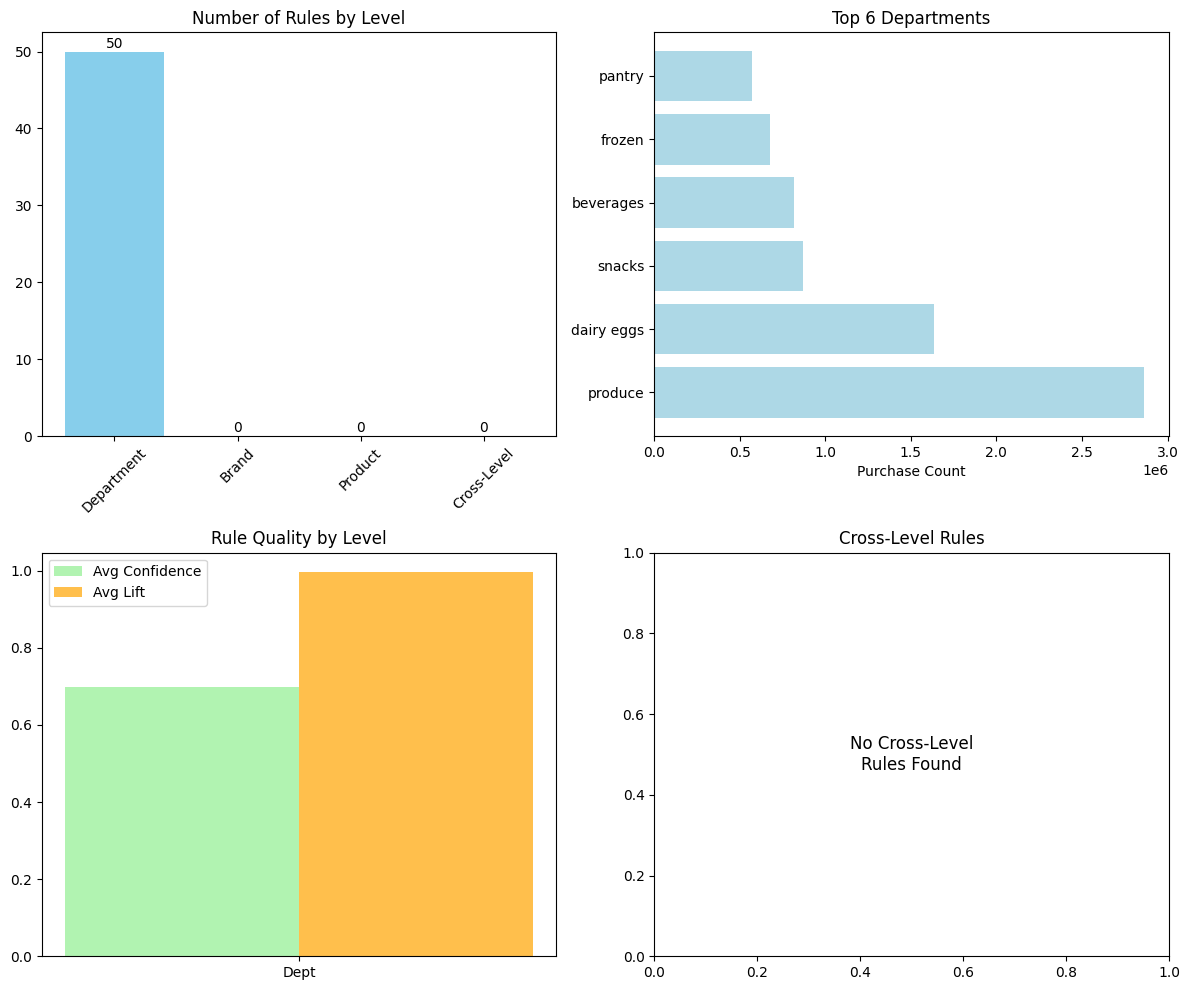

In [9]:
def create_fast_visualizations(rules_dept, rules_brand, rules_product, cross_level_rules):
    """Create quick visualizations without heavy processing"""

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 1. Rules count by level
    rules_count = [
        len(rules_dept) if len(rules_dept) > 0 else 0,
        len(rules_brand) if len(rules_brand) > 0 else 0,
        len(rules_product) if len(rules_product) > 0 else 0,
        len(cross_level_rules) if len(cross_level_rules) > 0 else 0
    ]
    levels = ['Department', 'Brand', 'Product', 'Cross-Level']

    bars = axes[0,0].bar(levels, rules_count, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    axes[0,0].set_title('Number of Rules by Level')
    axes[0,0].tick_params(axis='x', rotation=45)
    # Add value labels on bars
    for bar, count in zip(bars, rules_count):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                      str(count), ha='center', va='bottom')

    # 2. Top departments (pre-computed)
    dept_counts = order_hierarchy['department'].value_counts().head(6)
    axes[0,1].barh(range(len(dept_counts)), dept_counts.values, color='lightblue')
    axes[0,1].set_yticks(range(len(dept_counts)))
    axes[0,1].set_yticklabels([dept[:12] + '...' if len(dept) > 12 else dept for dept in dept_counts.index])
    axes[0,1].set_title('Top 6 Departments')
    axes[0,1].set_xlabel('Purchase Count')

    # 3. Rule quality metrics
    metrics_data = {}
    if len(rules_dept) > 0:
        metrics_data['Dept'] = [rules_dept['confidence'].mean(), rules_dept['lift'].mean()]
    if len(rules_brand) > 0:
        metrics_data['Brand'] = [rules_brand['confidence'].mean(), rules_brand['lift'].mean()]
    if len(rules_product) > 0:
        metrics_data['Product'] = [rules_product['confidence'].mean(), rules_product['lift'].mean()]

    if metrics_data:
        x = range(len(metrics_data))
        confidences = [metrics_data[key][0] for key in metrics_data]
        lifts = [metrics_data[key][1] for key in metrics_data]

        width = 0.35
        axes[1,0].bar(x, confidences, width, label='Avg Confidence', color='lightgreen', alpha=0.7)
        axes[1,0].bar([i + width for i in x], lifts, width, label='Avg Lift', color='orange', alpha=0.7)
        axes[1,0].set_xticks([i + width/2 for i in x])
        axes[1,0].set_xticklabels(metrics_data.keys())
        axes[1,0].set_title('Rule Quality by Level')
        axes[1,0].legend()

    # 4. Cross-level rules strength
    if len(cross_level_rules) > 0:
        top_cross = cross_level_rules.head(3)
        rule_labels = [f"Rule {i+1}" for i in range(len(top_cross))]
        confidences = top_cross['confidence'].values
        lifts = top_cross['lift'].values

        x = np.arange(len(rule_labels))
        width = 0.35

        axes[1,1].bar(x - width/2, confidences, width, label='Confidence', color='purple', alpha=0.7)
        axes[1,1].bar(x + width/2, lifts, width, label='Lift', color='red', alpha=0.7)
        axes[1,1].set_xticks(x)
        axes[1,1].set_xticklabels(rule_labels)
        axes[1,1].set_title('Top Cross-Level Rules\nQuality Metrics')
        axes[1,1].legend()
    else:
        axes[1,1].text(0.5, 0.5, 'No Cross-Level\nRules Found',
                      ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_title('Cross-Level Rules')

    plt.tight_layout()
    plt.show()

# Create fast visualizations
print("Creating fast visualizations...")
create_fast_visualizations(rules_dept, rules_brand, rules_product, cross_level_rules)

In [10]:
# Clean up memory efficiently
def cleanup_memory():
    """Clean up large objects to free memory"""
    large_objects = ['transactions_department', 'transactions_brand', 'transactions_product',
                    'transactions_all_levels', 'order_products_prior', 'orders']

    for obj in large_objects:
        if obj in globals():
            del globals()[obj]
            print(f"Deleted {obj}")

    import gc
    gc.collect()
    print("Memory cleanup completed!")

# Run cleanup
cleanup_memory()

Deleted transactions_department
Deleted transactions_brand
Deleted transactions_product
Deleted transactions_all_levels
Deleted order_products_prior
Deleted orders
Memory cleanup completed!


In [11]:
def generate_fast_insights():
    """Generate quick insights without heavy processing"""

    print("="*70)
    print("MULTILEVEL ASSOCIATION RULES - KEY INSIGHTS")
    print("="*70)

    # Quick stats
    total_rules = (len(rules_dept_analyzed) + len(rules_brand_analyzed) +
                   len(rules_product_analyzed) + len(cross_level_rules))

    print(f"\nQUICK SUMMARY:")
    print(f"• Total rules discovered: {total_rules}")
    print(f"• Department-level rules: {len(rules_dept_analyzed)}")
    print(f"• Brand-level rules: {len(rules_brand_analyzed)}")
    print(f"• Product-level rules: {len(rules_product_analyzed)}")
    print(f"• Cross-level rules: {len(cross_level_rules)}")

    print(f"\nUNIQUE MULTILEVEL INSIGHTS:")
    if len(cross_level_rules) > 0:
        print("✓ Found hierarchical shopping patterns across levels")
        best_cross = cross_level_rules.iloc[0] if len(cross_level_rules) > 0 else None
        if best_cross is not None:
            print(f"  Example: {list(best_cross['antecedents'])} → {list(best_cross['consequents'])}")
            print(f"  (Confidence: {best_cross['confidence']:.3f})")
    else:
        print("✓ Strong patterns found within individual hierarchy levels")

    print(f"\nBUSINESS IMPLICATIONS:")
    if len(rules_dept_analyzed) > 0:
        print("• Department rules → Store layout optimization")
    if len(rules_brand_analyzed) > 0:
        print("• Brand rules → Vendor partnership strategies")
    if len(cross_level_rules) > 0:
        print("• Cross-level rules → Targeted marketing campaigns")

    # Show strongest rule from each level
    print(f"\nSTRONGEST RULES BY LEVEL:")
    levels_data = [
        ("Department", rules_dept_analyzed),
        ("Brand", rules_brand_analyzed),
        ("Product", rules_product_analyzed)
    ]

    for level_name, rules in levels_data:
        if len(rules) > 0:
            best_rule = rules.iloc[0]
            print(f"• {level_name}: {list(best_rule['antecedents'])[:1]} → {list(best_rule['consequents'])[:1]}")
            print(f"  Confidence: {best_rule['confidence']:.3f}")

generate_fast_insights()

MULTILEVEL ASSOCIATION RULES - KEY INSIGHTS

QUICK SUMMARY:
• Total rules discovered: 8
• Department-level rules: 8
• Brand-level rules: 0
• Product-level rules: 0
• Cross-level rules: 0

UNIQUE MULTILEVEL INSIGHTS:
✓ Strong patterns found within individual hierarchy levels

BUSINESS IMPLICATIONS:
• Department rules → Store layout optimization

STRONGEST RULES BY LEVEL:
• Department: ['DEPT_babies'] → ['DEPT_beverages']
  Confidence: 0.641
